<center>
<h1><b>Prompt Engineering </b>
<h1><b>Classification tasks : Sentiment Analysis </b>
</center>

## Imports

In [48]:
import openai
import json
import tiktoken
import session_info
import pandas as pd
import numpy as np
from datasets import load_dataset
from collections import Counter
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_community.llms import Ollama

In [200]:
session_info.show()

## API Keys 

## Large Language Models

## How to count Tokens

In [201]:
encoding = tiktoken.encoding_for_model("gpt-4-turbo")
system_message =""" 
Peform Sentiment analysis of the revview presented in the user message.
The result should be positive or negative. Do not justify your response
"""
print(encoding.encode(system_message))

[720, 10407, 630, 24248, 3904, 6492, 315, 279, 5891, 1068, 10666, 304, 279, 1217, 1984, 627, 791, 1121, 1288, 387, 6928, 477, 8389, 13, 3234, 539, 9541, 701, 2077, 198]


## Test OpenAI

In [197]:
OPEN_AI_KEY = "sk-proj-bkkDQOUCtyf7Ctj2afRXT3BlbkFJtxzf8IbMmA6uqAd1qt9j"
gpt4_llm = ChatOpenAI(model="gpt-4-turbo", temperature=0, api_key=OPEN_AI_KEY)
system_message =""" 
Classify the sentiment of the review presented in the input as 'positive' or 'negative'
The review will be delimited by triple backticks ``` in the input.
Answer only 'positive' or 'negative' 
Do not explain your answer.
"""
user_message_template ="```{review}```"
user_message ="I think that your services are very fine"
zero_shot_prompt = [
    {"role":"system","content":system_message},
    {"role":"user", "content":user_message_template.format(review=user_message)},
]
response = gpt4_llm.invoke(zero_shot_prompt)
print(response.content)

positive


## Test Groq Mixtral

In [198]:
GROQ_API_KEY = "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"
groq_llm = ChatGroq(model_name="mixtral-8x7b-32768", temperature=0,  api_key=GROQ_API_KEY)
system_message =""" 
Classify the sentiment of the review presented in the input as 'positive' or 'negative'
The review will be delimited by triple backticks ``` in the input.
Answer only 'positive' or 'negative' 
Do not explain your answer.
"""
user_message_template ="```{review}```"
user_message ="I think that your services are very fine"
zero_shot_prompt = [
    {"role":"system","content":system_message},
    {"role":"user", "content":user_message_template.format(review=user_message)},
]
response = groq_llm.invoke(zero_shot_prompt)
print(response.content.replace("</s>",""))

positive


## Test Ollama (Local Machine)

In [203]:
llama_llm  = Ollama(model="llama3", temperature=0)
system_message =""" 
Classify the sentiment of the review presented in the input as 'positive' or 'negative'
The review will be delimited by triple backticks ``` in the input.
Answer only 'positive' or 'negative'.
Do not explain your answer.
"""
user_message_template ="```{review}```"
user_message1 ="I think that your services are very fine"
assistant_response1 ="positive"
user_message2 ="I do not like the food```"""
assistant_response2 ="negative"
user_message ="The look is bad"
few_shot_prompt = [
    {"role":"system","content":system_message},
    {"role":"user", "content":user_message_template.format(review=user_message1)},
    {"role":"assistant", "content":assistant_response1},
    {"role":"user", "content":user_message_template.format(review=user_message2)},
    {"role":"assistant", "content":assistant_response2},
    {"role":"user", "content":user_message_template.format(review=user_message)},
]
response = llama_llm.invoke(few_shot_prompt)
print(response)

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start_header_id|>assistant<|end_header_id|>

positive<|eot_id|><|start

### Step 2: Assemble Data

In [66]:
corpus = load_dataset("imdb")

In [67]:
corpus

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [69]:
train_df = corpus['train'].to_pandas()

In [70]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [71]:
train_df.label.value_counts()

label
0    12500
1    12500
Name: count, dtype: int64

Note how the dataset is evenly balanced with equal number of reviews assembled for positive (label 1) and negative sentiment (label 0).

In order to facilitate comparison of the ground truth labels with model predictions, let us add the corresponding text label as an additional column to the data.

In [72]:
train_df['sentiment'] = np.where(train_df.label == 1, "positive", "negative")

In [74]:
train_df.sample(6)

,text,label,sentiment
15474,It is noteworthy that mine is only the third r...,1,positive
5630,"Shazbot, is this embarrassing. In fact, here's...",0,negative
8958,With no fault to the actors (they all put on g...,0,negative
22695,This great movie has failed to register a high...,1,positive
18570,"OK, I overrated it just a bit to offset at lea...",1,positive
17112,This is definitely one of Jet's best efforts. ...,1,positive


We now have the dataset in the correct format to be parsed by LLM.

In [75]:
train_df.sentiment.value_counts()

sentiment
negative    12500
positive    12500
Name: count, dtype: int64

<Axes: >

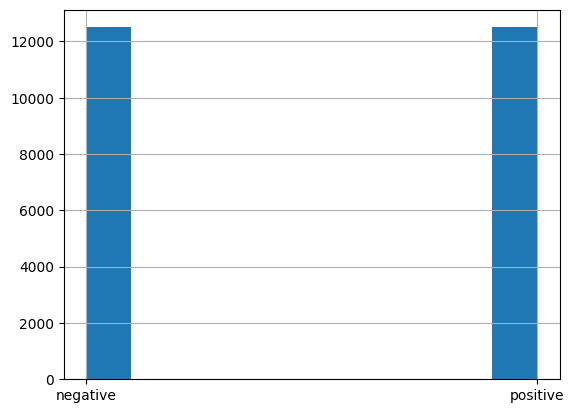

In [155]:
train_df.sentiment.hist()

In [76]:
examples_df, gold_examples_df = train_test_split(
    train_df, test_size=0.2, random_state=42 
)

In [77]:
(examples_df.shape, gold_examples_df.shape)

((20000, 3), (5000, 3))

To select gold examples for this session, we sample randomly from the test data using a `random_state=42`. This ensures that the examples from multiple runs of the sampling are the same (i.e., they are randomly selected but do not change between different runs of the notebook). Note that we are doing this only to keep execution times low for illustration. In practise, large number of gold examples facilitate robust estimates of model accuracy.

In [114]:
columns= ['text', 'sentiment']
gold_examples = ( gold_examples_df.loc[:, columns].sample(20, random_state=42).to_json(orient='records'))

In [80]:
json.loads(gold_examples)[0]

{'text': 'Like I said at the top, four stars just aren\'t enough. It\'s one of the best films I\'ve ever seen in my almost 17 years of life. For the people that don\'t really like it or understand it, you must not have a real appreciation for art or you might have a short attention span.<br /><br />Even if I haven\'t seen all his films yet, I\'d have to say that this is Spielberg at his peak. It\'s pretty sad to see that movies as great as "The Color Purple" don\'t come along too often \'cause I think all of us are in desperate need of first-class motion picture entertainment in these hard times.<br /><br />Movies like this are more than just movies; they\'re pieces of art that need to be appreciated more.<br /><br />The idea that it was nominated for 11 Oscars (even Best Picture of the Year) and didn\'t get one trophy is a sign of how blind and stupid Hollywood can be sometimes. Spielberg wasn\'t even nominated for Best Director! It should have swept the Oscars that year.<br /><br />T

### Step 3: Derive Prompt

#### Create prompts

In [81]:
user_message_template = """```{movie_review}```"""

**Prompt 1: Zero-shot**

In [126]:
zero_shot_system_message = """
Classify the sentiment of movie reviews presented in the input as 'positive' or 'negative'
Movie reviews will be delimited by triple backticks in the input.
Answer only 'positive' or 'negative' 
Do not explain your answer.
"""

In [83]:
zero_shot_prompt = [{'role':'system', 'content': zero_shot_system_message}]

**Prompt 2: Few-shot**

For the few-shot prompt, there is no change in the system message compared with the zero-shot prompt. However, we augment this system message with few shot examples.  

In [127]:
few_shot_system_message = """
Classify the sentiment of movie reviews presented in the input as 'positive' or 'negative'
Movie reviews will be delimited by triple backticks in the input.
Answer only 'positive' or 'negative'
Do not explain your answer.
"""

To assemble few-shot examples, we will need to sample the required number of reviews from the training data. One approach would be to  first subset positive and negative reviews and then select samples from these subsets like so (note how we assemble 8 few-shot examples in the code below):

In [85]:
positive_reviews = (examples_df.sentiment == 'positive')
negative_reviews = (examples_df.sentiment == 'negative')

In [86]:
(positive_reviews.shape, negative_reviews.shape)

((20000,), (20000,))

In [87]:
columns = ['text', 'sentiment']
positive_examples = examples_df.loc[positive_reviews, columns].sample(4)
negative_examples = examples_df.loc[negative_reviews, columns].sample(4)

In [88]:
positive_examples

,text,sentiment
19171,One of my favorite shows in the 80's. After th...,positive
22462,<br /><br />Presenting Lily Mars is one of a g...,positive
18428,Every movie critic and metal head hated this m...,positive
16281,When will people learn that some movies are ma...,positive


In [89]:
negative_examples

,text,sentiment
11058,TYSON <br /><br />Aspect ratio: 1.33:1<br /><b...,negative
4734,"This was a crappy movie, with a whole lotta no...",negative
4631,"This show is possibly the biggest, ugliest, mo...",negative
7971,Please! Do not waste any money on this movie. ...,negative


However, merely selecting random samples from the polarity subsets is not enough because the examples included in a prompt are prone to a set of known biases such as:
 - Majority label bias (frequent answers in predictions)
 - Recency bias (examples near the end of the prompt)


To avoid these biases, it is important to have a balanced set of examples that are arranged in random order. Let us create a Python function that generates bias-free examples (our function implements the workflow presented below):

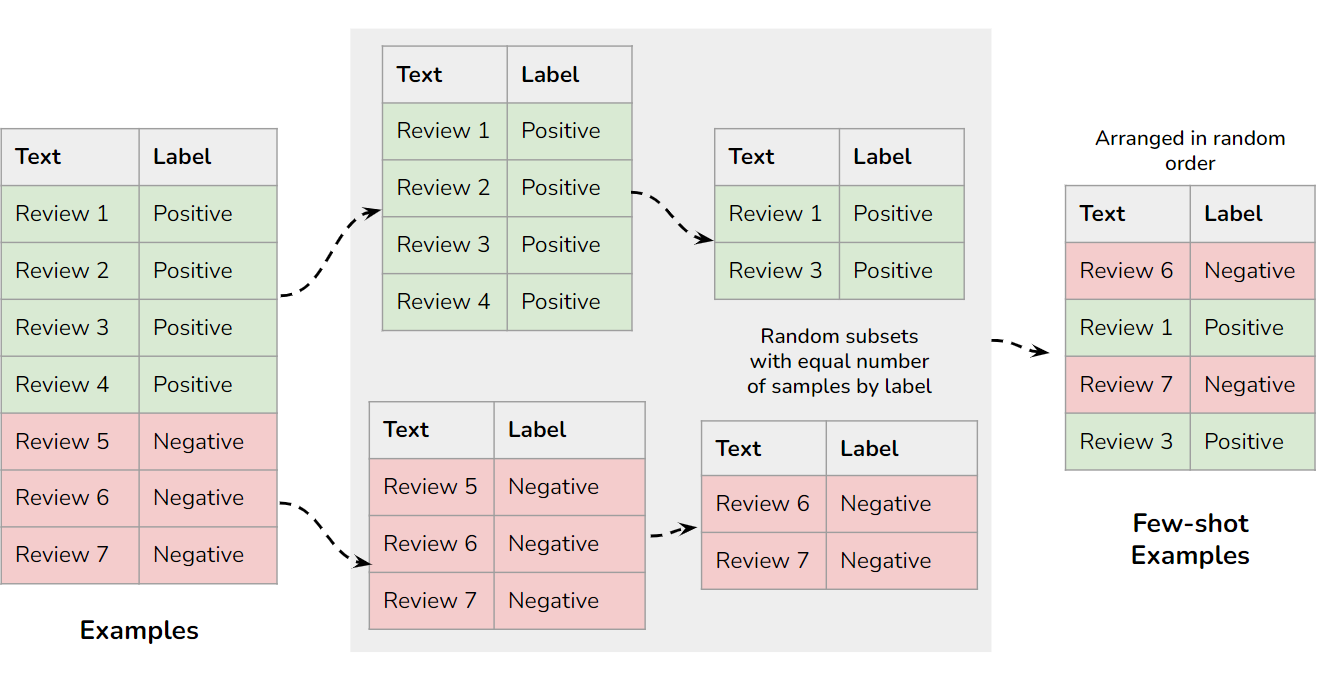

In [90]:
def create_examples(dataset, n=4):
    positive_reviews = (dataset.sentiment == 'positive')
    negative_reviews = (dataset.sentiment == 'negative')
    columns_to_select = ['text', 'sentiment']
    positive_examples = dataset.loc[positive_reviews, columns_to_select].sample(n)
    negative_examples = dataset.loc[negative_reviews, columns_to_select].sample(n)
    examples = pd.concat([positive_examples, negative_examples])
    # sampling without replacement is equivalent to random shuffling
    randomized_examples = examples.sample(2*n, replace=False)
    return randomized_examples.to_json(orient='records')

In [91]:
examples = create_examples(examples_df, 2)

In [92]:
json.loads(examples)

[{'text': "What can you say about this movie? It was not terrible, but it was not good! Two days earlier I had watched Lillies and that was one of the best Gay films I have ever seen. So this was not the best time to watch a mediocre Gay flick.<br /><br />The story was silly and the acting was OK. It was not bad enough to turn off, but it had some bad moments and some terrible stereotyping. It was not very well cast either.<br /><br />Would I recommend this movie? No you would be wasting your time and money. I don't understand why movies like these are made and who is funding them. Spend your time Watching Noah's Arc on Logo instead. I think this is where this movie was trying to go but never got there.",
  'sentiment': 'negative'},
 {'text': "I saw this movie at a college film festival back in the 70's - I have been waiting FOREVER for this movie to come out on video (finally it's out). It was made in Brazil, so I assumed that was why it hadn't made it to video yet. I have been checki

With the examples in place, we can now assemble a few-shot prompt. Since we will be using the few-shot prompt several times during evaluation, let us write a function to create a few-shot prompt (the logic of this function is depicted below).

In [128]:
def create_prompt(system_message, examples, user_message_template):
    few_shot_prompt = [{'role':'system', 'content': system_message}]
    for example in json.loads(examples):
        example_review = example['text']
        example_sentiment = example['sentiment']
        few_shot_prompt.append(
            {
                'role': 'user',
                'content': user_message_template.format(
                    movie_review=example_review
                )
            }
        )
        few_shot_prompt.append(
            {'role': 'assistant', 'content': f"{example_sentiment}"}
        )
    return few_shot_prompt

In [129]:
few_shot_prompt = create_prompt(
    few_shot_system_message,
    examples,
    user_message_template
)

In [130]:
few_shot_prompt

[{'role': 'system',
  'content': "\nClassify the sentiment of movie reviews presented in the input as 'positive' or 'negative'\nMovie reviews will be delimited by triple backticks in the input.\nAnswer only 'positive' or 'negative'\nDo not explain your answer.\n"},
 {'role': 'user',
  'content': "```What can you say about this movie? It was not terrible, but it was not good! Two days earlier I had watched Lillies and that was one of the best Gay films I have ever seen. So this was not the best time to watch a mediocre Gay flick.<br /><br />The story was silly and the acting was OK. It was not bad enough to turn off, but it had some bad moments and some terrible stereotyping. It was not very well cast either.<br /><br />Would I recommend this movie? No you would be wasting your time and money. I don't understand why movies like these are made and who is funding them. Spend your time Watching Noah's Arc on Logo instead. I think this is where this movie was trying to go but never got ther

**Prompt 3: Chain-of-Thought**

For the CoT prompt, we add detailed step-by-step instructions to the few shot system message instructing the model to carefully ponder before assigning sentiment. Apart from this addition, there are no further changes from the few-shot prompt.

In [131]:
cot_system_message = """
Classify the sentiment of movie reviews presented in the input as 'positive' or 'negative'
Movie reviews will be delimited by triple backticks ``` in the input.
Answer only 'positive' or 'negative' 
Do not explain your answer.

Instructions:
1. Carefully read the text of the review and think through the options for sentiment provided
2. Consider the overall sentiment of the review and estimate the probability of the review being positive

To reiterate, your answer should strictly only contain the label: positive or negative
"""

In [132]:
cot_few_shot_prompt = create_prompt(cot_system_message, examples, user_message_template)

In [133]:
cot_few_shot_prompt

[{'role': 'system',
  'content': "\nClassify the sentiment of movie reviews presented in the input as 'positive' or 'negative'\nMovie reviews will be delimited by triple backticks in the input.\nAnswer only 'positive' or 'negative' \nDo not explain your answer.\n\nInstructions:\n1. Carefully read the text of the review and think through the options for sentiment provided\n2. Consider the overall sentiment of the review and estimate the probability of the review being positive\n\nTo reiterate, your answer should strictly only contain the label: positive or negative\n"},
 {'role': 'user',
  'content': "```What can you say about this movie? It was not terrible, but it was not good! Two days earlier I had watched Lillies and that was one of the best Gay films I have ever seen. So this was not the best time to watch a mediocre Gay flick.<br /><br />The story was silly and the acting was OK. It was not bad enough to turn off, but it had some bad moments and some terrible stereotyping. It was

Note that the examples remain the same while the system message changes.

#### Evaluate prompts

Now we have three sets of prompts that we need to evaluate using gold labels. Since the few-shot prompt and the CoT prompt depend on the sample of examples that was drawn to make up the prompt, we expect some variability in evaluation. Hence, we evaluate each prompt multiple times to get a sense of the average and the variation around the average.

To reiterate, a choice on the prompt should account for variability due to the choice of the random sample. To aid repeated evaluation, we assemble an evaluation function (overall logic depicted in the figure below).

In [150]:
def evaluate_prompt(prompt, gold_examples, user_message_template, model):
    model_predictions, ground_truths = [], []

    for example in json.loads(gold_examples):
        gold_input = example['text']
        user_input = [
            {
                'role':'user',
                'content': user_message_template.format(movie_review=gold_input)
            }
        ]

        try:
            response = model.invoke(
               prompt+user_input
            )
            if hasattr (response, 'content'):
                response_content = response.content
            else:
                response_content = response    
            if 'negative' in response_content.strip().lower():
                prediction='negative'
            elif 'positive' in response_content.strip().lower():
                prediction='positive'
            else:
                prediction ='unknown'
            model_predictions.append(prediction)
            ground_truths.append(example['sentiment'])
            print(prediction, example['sentiment'])

        except Exception as e:
            print(e)
            continue

    micro_f1_score = f1_score(ground_truths, model_predictions, average="micro")

    return micro_f1_score

Let us now use this function to do one evaluation of all the three prompts assembled so far, each time computing the Micro-F1 score.

In [153]:
evaluate_prompt(zero_shot_prompt, gold_examples, user_message_template, llama_llm)

positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative
positive positive


1.0

In [142]:
evaluate_prompt(few_shot_prompt, gold_examples, user_message_template)

positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative
positive positive


1.0

In [143]:
evaluate_prompt(cot_few_shot_prompt, gold_examples, user_message_template)

positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative
positive positive


1.0

However, this is just *one* choice of examples. We will need to run these evaluations with multiple choices of examples to get a sense of variability in F1 score for the few-shot prompt and the CoT prompt. As an example, let us run evaluations for the few-shot prompt and the CoT prompt 10 times.

In [144]:
num_eval_runs = 10

In [145]:
few_shot_performance, cot_few_shot_performance = [], []

In [147]:
for _ in tqdm(range(num_eval_runs)):

    # For each run create a new sample of examples
    examples = create_examples(examples_df)

    # Assemble the few shot prompt with these examples
    few_shot_prompt = create_prompt(few_shot_system_message, examples, user_message_template)
    cot_few_shot_prompt = create_prompt(cot_system_message, examples, user_message_template)

    # Evaluate prompt accuracy on gold examples
    few_shot_micro_f1 = evaluate_prompt(few_shot_prompt, gold_examples, user_message_template)
    cot_few_shot_micro_f1 = evaluate_prompt(cot_few_shot_prompt, gold_examples, user_message_template)

    few_shot_performance.append(few_shot_micro_f1)
    cot_few_shot_performance.append(cot_few_shot_micro_f1)

  0%|          | 0/10 [00:00<?, ?it/s]

positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative
positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative


 10%|█         | 1/10 [00:41<06:09, 41.06s/it]

positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative
positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative


 20%|██        | 2/10 [01:24<05:41, 42.69s/it]

positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative
positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative


 30%|███       | 3/10 [02:08<05:00, 42.99s/it]

positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative
positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative


 40%|████      | 4/10 [02:50<04:16, 42.81s/it]

positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative
positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative


 50%|█████     | 5/10 [03:37<03:40, 44.19s/it]

positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative
positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative


 60%|██████    | 6/10 [04:24<03:00, 45.09s/it]

positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative
positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative


 70%|███████   | 7/10 [05:05<02:11, 43.69s/it]

positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative
positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative


 80%|████████  | 8/10 [05:49<01:27, 43.96s/it]

positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative
positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative


 90%|█████████ | 9/10 [06:45<00:47, 47.59s/it]

positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative
positive positive
positive positive
negative negative
negative negative
negative negative
negative negative
negative negative
negative negative
positive positive
negative negative
negative negative
negative negative
positive positive
negative negative
positive positive
positive positive
positive positive
negative negative
positive positive
negative negative


100%|██████████| 10/10 [07:32<00:00, 45.23s/it]

positive positive


In [148]:
np.array(few_shot_performance).mean(), np.array(few_shot_performance).std()

(1.0, 0.0)

In [149]:
np.array(cot_few_shot_performance).mean(), np.array(cot_few_shot_performance).std()

(1.0, 0.0)